# Wavelength Selection Validation Pipeline - ENHANCED WITH COMPREHENSIVE VISUALIZATIONS

This notebook provides a comprehensive validation pipeline for wavelength selection with:
- **UPDATED**: Now uses **KNN-based clustering** instead of KMeans 
- **UPDATED**: Integrates improved data processing from `clustering_experiments.ipynb`
- Fixed wavelength extraction (no more TypeError!)
- Clear excitation-emission wavelength combinations
- Multiple meaningful configurations
- Results saved to DataFrame and Excel
- Clustering visualizations saved for each configuration

## Key Integration Changes:
- ✅ **Concatenated KNN** replaces concatenated KMeans for both baseline and subsets
- ✅ **Improved data processing**: Integer coordinates, global normalization, valid pixels only
- ✅ **ROI-based training**: Uses spatial regions for supervised classification
- ✅ **Same workflow**: All wavelength selection logic maintained

## 1. Setup and Imports

In [1]:
import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
import random
random.seed(42)
import torch
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Setup paths
base_dir = Path(r"C:\Users\meloy\PycharmProjects\Capstone")
sys.path.append(str(base_dir))
sys.path.append(str(base_dir / "wavelength_analysis"))

# Create results directory with subdirectories
results_dir = base_dir / "wavelength_analysis" / "validation_results" / datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir.mkdir(parents=True, exist_ok=True)
visualizations_dir = results_dir / "visualizations"
visualizations_dir.mkdir(exist_ok=True)

# NEW: Create paper-results and concat-data directories
paper_results_dir = results_dir / "paper-results"
paper_results_dir.mkdir(exist_ok=True)
concat_data_dir = results_dir / "concat-data"
concat_data_dir.mkdir(exist_ok=True)

print("Environment setup completed")
print(f"  Working directory: {base_dir}")
print(f"  Results directory: {results_dir}")
print(f"  Paper results directory: {paper_results_dir}")
print(f"  Concatenated data directory: {concat_data_dir}")
print(f"  Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

Environment setup completed
  Working directory: C:\Users\meloy\PycharmProjects\Capstone
  Results directory: C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\validation_results\20251015_113356
  Paper results directory: C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\validation_results\20251015_113356\paper-results
  Concatenated data directory: C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\validation_results\20251015_113356\concat-data
  Device: CUDA


In [2]:
# Import enhanced visualization module
from enhanced_viz_module import *

# Create visualization directory structure
vis_dir = create_visualization_dirs()
print(f"📁 Visualizations will be saved to: {vis_dir}")

# Set visualization parameters
VIZ_DPI = 300  # High quality for paper
VIZ_PALETTE = "paper"  # Color palette for consistency


Enhanced Visualization Module Loaded
Available functions:
  • create_visualization_dirs()
  • export_roi_overlay()
  • create_method_comparison()
  • plot_spectral_signatures()
  • create_wavelength_importance_plot()
  • calculate_advanced_metrics()
  • create_latent_space_plot()
  • create_distribution_plots()
  • create_paper_figure()
  • generate_all_visualizations()
📁 Visualization directories created at: results\enhanced_visualizations
📁 Visualizations will be saved to: results\enhanced_visualizations


In [3]:
# Import required modules
from wavelength_analysis.core.config import AnalysisConfig
from wavelength_analysis.core.analyzer import WavelengthAnalyzer
from concatenation_clustering import (
    load_masked_data,
    concatenate_hyperspectral_data_improved,  # Use improved version
    perform_clustering,
    reconstruct_cluster_map
)
from ground_truth_validation import (
    extract_ground_truth_from_png,
    calculate_clustering_accuracy
)

# Import KNN-related libraries for the new pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("All modules imported successfully (with KNN support)")

All modules imported successfully (with KNN support)


## 2. Core Functions (UPDATED with KNN)

**IMPORTANT UPDATE**: This pipeline now uses **KNN-based clustering** instead of KMeans for both baseline and wavelength subset evaluation. The approach integrates the improved data processing from `clustering_experiments.ipynb`:

### Key Changes:
1. **Concatenated KNN** replaces concatenated KMeans
2. **Improved data processing**: Uses `concatenate_hyperspectral_data_improved()` with:
   - Integer coordinates (no normalization)
   - Global spectral normalization (not column-wise) 
   - Valid pixels only processing
3. **ROI-based training**: KNN uses ROI regions for supervised classification
4. **Fallback to KMeans**: If ROI training fails, falls back to improved KMeans

### Benefits:
- Better baseline performance than concatenated KMeans
- More consistent data processing pipeline
- Leverages spatial structure through ROI training
- Maintains all existing wavelength selection logic

In [4]:
def select_informative_wavelengths_fixed(data_path, mask_path, sample_name, config_params, verbose=True):
    """
    FIXED VERSION: Returns actual wavelength combinations with excitation-emission pairs!
    """
    # Create model directory
    model_dir = base_dir / "results" / f"{sample_name}_wavelength_selection" / "model"
    model_dir.mkdir(parents=True, exist_ok=True)
    model_path = model_dir / "autoencoder_model.pth"
    
    # Create configuration
    config = AnalysisConfig(
        sample_name=sample_name,
        data_path=str(data_path),
        mask_path=str(mask_path),
        model_path=str(model_path),
        dimension_selection_method=config_params.get('dimension_selection_method', 'activation'),
        perturbation_method=config_params.get('perturbation_method', 'percentile'),
        perturbation_magnitudes=config_params.get('perturbation_magnitudes', [10, 20, 30]),
        n_important_dimensions=config_params.get('n_important_dimensions', 15),
        n_bands_to_select=config_params.get('n_bands_to_select', 30),
        normalization_method=config_params.get('normalization_method', 'variance'),
        output_dir=str(model_dir.parent / "output"),
        save_tiff_layers=False,
        save_visualizations=False,
        n_baseline_patches=10
    )
    
    if verbose:
        print(f"\nRunning wavelength selection: {config_params.get('name', 'unnamed')}")
    
    # Initialize analyzer
    analyzer = WavelengthAnalyzer(config)
    
    # Load data and model
    analyzer.load_data_and_model()
    
    # Run wavelength selection analysis
    results = analyzer.run_complete_analysis()
    
    if results is None or 'selected_bands' not in results:
        raise ValueError("Wavelength selection failed to return results")
    
    # FIXED: Extract excitation-emission wavelength combinations
    selected_bands_raw = results['selected_bands']
    wavelength_combinations = []
    emission_wavelengths_only = []
    
    for band in selected_bands_raw:
        if isinstance(band, dict):
            excitation = band.get('excitation', 'unknown')
            emission = band.get('emission_wavelength', 'unknown')
            
            # Convert numpy to regular Python float/int
            if hasattr(excitation, 'item'):
                excitation = float(excitation.item())
            else:
                excitation = float(excitation)
                
            if hasattr(emission, 'item'):
                emission = float(emission.item())
            else:
                emission = float(emission)
            
            # Store the combination
            combination = {
                'excitation': excitation,
                'emission': emission,
                'combination_name': f"Ex{excitation:.0f}_Em{emission:.1f}"
            }
            wavelength_combinations.append(combination)
            
            # Also keep emission wavelengths for backward compatibility
            emission_wavelengths_only.append(emission)
    
    # Remove duplicates while preserving order
    seen_combinations = set()
    unique_combinations = []
    unique_emissions = []
    
    for combo, emission in zip(wavelength_combinations, emission_wavelengths_only):
        combo_key = (combo['excitation'], combo['emission'])
        if combo_key not in seen_combinations:
            seen_combinations.add(combo_key)
            unique_combinations.append(combo)
            unique_emissions.append(emission)
    
    if verbose:
        print(f"  Selected {len(unique_combinations)} unique wavelength combinations")
        if unique_combinations:
            print(f"  First few: {[c['combination_name'] for c in unique_combinations[:3]]}...")
    
    return unique_combinations, unique_emissions, results


def extract_wavelength_subset(full_data, emission_wavelengths_only, verbose=False):
    """
    Extract subset of data using selected emission wavelengths.
    Uses emission_wavelengths_only for backward compatibility.
    """
    subset_data = {
        'data': {},
        'metadata': full_data.get('metadata', {}),
        'excitation_wavelengths': full_data['excitation_wavelengths'],
        'selected_wavelengths': emission_wavelengths_only
    }
    
    total_bands_original = 0
    total_bands_selected = 0
    
    for ex in full_data['excitation_wavelengths']:
        ex_str = str(ex)
        ex_data = full_data['data'][ex_str]
        
        original_wavelengths = np.array(ex_data['wavelengths'])
        original_cube = ex_data['cube']
        
        total_bands_original += len(original_wavelengths)
        
        # Find indices of selected wavelengths for this excitation
        selected_indices = []
        selected_wl_values = []
        
        for target_wl in emission_wavelengths_only:
            # Ensure target_wl is a number
            target_wl = float(target_wl)
            
            # Find closest wavelength
            distances = np.abs(original_wavelengths - target_wl)
            closest_idx = np.argmin(distances)
            
            # Only include if reasonably close (within 10 nm) and not duplicate
            if distances[closest_idx] < 10 and closest_idx not in selected_indices:
                selected_indices.append(closest_idx)
                selected_wl_values.append(original_wavelengths[closest_idx])
        
        if selected_indices:
            subset_cube = original_cube[:, :, selected_indices]
            total_bands_selected += len(selected_indices)
            
            subset_data['data'][ex_str] = {
                'cube': subset_cube,
                'wavelengths': selected_wl_values,
                **{k: v for k, v in ex_data.items() if k not in ['cube', 'wavelengths']}
            }
        else:
            # Keep all bands if none selected
            subset_data['data'][ex_str] = ex_data
            total_bands_selected += len(original_wavelengths)
    
    if verbose:
        reduction_pct = (1 - total_bands_selected/total_bands_original) * 100
        print(f"  Data reduction: {total_bands_original} → {total_bands_selected} bands ({reduction_pct:.1f}% reduction)")
    
    return subset_data


# Define ROI regions with specific colors for consistency
ROI_REGIONS = [
    {'name': 'Region 1', 'coords': (175, 225, 100, 150), 'color': '#FF0000'},  # Red
    {'name': 'Region 2', 'coords': (175, 225, 250, 300), 'color': '#0000FF'},  # Blue
    {'name': 'Region 3', 'coords': (175, 225, 425, 475), 'color': '#00FF00'},  # Green
    {'name': 'Region 4', 'coords': (175, 225, 650, 700), 'color': '#FFFF00'},  # Yellow
]


def create_roi_colormap(roi_regions):
    """
    Create a custom colormap based on ROI region colors.
    Maps cluster IDs directly to ROI colors.
    """
    # Create colors list matching cluster IDs (0-3 for 4 regions)
    colors_list = []
    for roi in roi_regions:
        colors_list.append(roi['color'])
    
    # Add white for background/unassigned (-1) if needed
    # We'll handle -1 separately in visualization by masking
    
    return mcolors.ListedColormap(colors_list)


def run_knn_clustering_pipeline(data, n_clusters, roi_regions=None, random_state=42, export_concat_data=False, config_name=None):
    """
    NEW: Run complete KNN-based clustering pipeline using improved data processing.
    This replaces the old KMeans-based approach with KNN classification.
    
    Args:
        data: Hyperspectral data dictionary
        n_clusters: Number of clusters (used for evaluation metrics)
        roi_regions: ROI regions for training (if None, uses default regions)
        random_state: Random seed for reproducibility
        export_concat_data: If True, exports the concatenated data to CSV
        config_name: Name of the configuration (for file naming)
    
    Returns:
        cluster_map: 2D array with cluster assignments
        metrics: Dictionary with clustering metrics
        n_features: Number of spectral features used
    """
    if roi_regions is None:
        roi_regions = ROI_REGIONS
    
    # Step 1: Use improved data concatenation (same as clustering_experiments.ipynb)
    df, valid_mask, metadata = concatenate_hyperspectral_data_improved(
        data,
        global_normalize=True,
        normalization_method='global_percentile'
    )
    
    # NEW: Export concatenated data if requested
    if export_concat_data and config_name:
        concat_filename = concat_data_dir / f"{config_name}_concatenated_data.csv"
        df.to_csv(concat_filename, index=False)
        print(f"    Exported concatenated data to: {concat_filename.name}")
    
    # Step 2: Extract ROI training data
    spectral_cols = [col for col in df.columns if col not in ['x', 'y']]
    X_train_list = []
    y_train_list = []
    
    # Create label mapping (ROI name -> numeric label)
    label_mapping = {roi['name']: i for i, roi in enumerate(roi_regions)}
    
    # Extract data from each ROI region
    for roi in roi_regions:
        roi_name = roi['name']
        y_start, y_end, x_start, x_end = roi['coords']
        
        # Find pixels within this ROI
        roi_mask = (
            (df['x'] >= x_start) & (df['x'] < x_end) &
            (df['y'] >= y_start) & (df['y'] < y_end)
        )
        
        roi_pixels = df[roi_mask]
        n_pixels = len(roi_pixels)
        
        if n_pixels > 0:
            # Extract spectral features for this ROI
            roi_spectra = roi_pixels[spectral_cols].values
            roi_labels = [label_mapping[roi_name]] * n_pixels
            
            X_train_list.append(roi_spectra)
            y_train_list.extend(roi_labels)
    
    # Combine all ROI data
    if X_train_list:
        X_train = np.vstack(X_train_list)
        y_train = np.array(y_train_list)
    else:
        # Fallback: use KMeans clustering if no ROI training data available
        return run_kmeans_fallback(df, valid_mask, metadata, n_clusters, random_state)
    
    # Step 3: Train KNN classifier
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Use simple KNN (no hyperparameter optimization for speed)
    knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    knn_model.fit(X_train_scaled, y_train)
    
    # Step 4: Apply to full image
    X_full = df[spectral_cols].values
    X_full_scaled = scaler.transform(X_full)
    predictions = knn_model.predict(X_full_scaled)
    
    # Step 5: Reconstruct cluster map
    height, width = metadata['height'], metadata['width']
    cluster_map = np.full((height, width), -1, dtype=int)
    
    # Fill in predictions for valid pixels
    for i, (_, row) in enumerate(df.iterrows()):
        x, y = int(row['x']), int(row['y'])
        cluster_map[y, x] = predictions[i]
    
    # Step 6: Calculate clustering metrics (adapted for KNN)
    # Since KNN predictions might not match n_clusters exactly, we adapt the metrics
    unique_labels = np.unique(predictions)
    n_actual_clusters = len(unique_labels)
    
    # Calculate basic metrics using spectral features
    try:
        from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
        
        # Sample data for metric calculation (to avoid memory issues)
        n_samples = min(10000, len(X_full_scaled))
        sample_indices = np.random.choice(len(X_full_scaled), n_samples, replace=False)
        X_sample = X_full_scaled[sample_indices]
        pred_sample = predictions[sample_indices]
        
        if len(np.unique(pred_sample)) > 1:
            silhouette = silhouette_score(X_sample, pred_sample)
            davies_bouldin = davies_bouldin_score(X_sample, pred_sample)
            calinski_harabasz = calinski_harabasz_score(X_sample, pred_sample)
        else:
            silhouette = 0.0
            davies_bouldin = float('inf')
            calinski_harabasz = 0.0
    except:
        silhouette = 0.0
        davies_bouldin = float('inf')
        calinski_harabasz = 0.0
    
    metrics = {
        'silhouette_score': silhouette,
        'davies_bouldin_score': davies_bouldin,
        'calinski_harabasz_score': calinski_harabasz,
        'n_clusters_found': n_actual_clusters,
        'cluster_counts': dict(zip(*np.unique(predictions, return_counts=True)))
    }
    
    n_features = len(spectral_cols)
    
    return cluster_map, metrics, n_features


def run_kmeans_fallback(df, valid_mask, metadata, n_clusters, random_state):
    """
    Fallback to improved KMeans clustering when ROI training fails.
    """
    # Perform clustering using improved approach
    spectral_cols = [col for col in df.columns if col not in ['x', 'y']]
    X = df[spectral_cols].values
    
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(X)
    
    # Reconstruct cluster map
    height, width = metadata['height'], metadata['width']
    cluster_map = np.full((height, width), -1, dtype=int)
    
    for i, (_, row) in enumerate(df.iterrows()):
        x, y = int(row['x']), int(row['y'])
        cluster_map[y, x] = labels[i]
    
    # Calculate metrics
    sample_size = min(10000, len(X))
    metrics = {
        'silhouette_score': silhouette_score(X, labels, sample_size=sample_size),
        'davies_bouldin_score': davies_bouldin_score(X, labels),
        'calinski_harabasz_score': calinski_harabasz_score(X, labels),
        'inertia': kmeans.inertia_
    }
    
    return cluster_map, metrics, len(spectral_cols)


# Keep old function name for backward compatibility
def run_clustering_pipeline(data, n_clusters, random_state=42, export_concat_data=False, config_name=None):
    """
    UPDATED: Now uses KNN-based clustering instead of KMeans.
    This maintains the same interface but uses the improved approach.
    """
    return run_knn_clustering_pipeline(data, n_clusters, roi_regions=ROI_REGIONS, random_state=random_state, 
                                      export_concat_data=export_concat_data, config_name=config_name)


def format_wavelength_combinations(combinations):
    """
    Format wavelength combinations into readable strings for Excel.
    """
    if not combinations:
        return "None"
    
    # Group by excitation wavelength
    by_excitation = {}
    for combo in combinations:
        ex = combo['excitation']
        em = combo['emission']
        if ex not in by_excitation:
            by_excitation[ex] = []
        by_excitation[ex].append(em)
    
    # Create formatted strings
    formatted_parts = []
    for ex, emissions in sorted(by_excitation.items()):
        emissions_str = ", ".join([f"{em:.1f}" for em in sorted(emissions)])
        formatted_parts.append(f"Ex{ex:.0f}nm: [{emissions_str}]nm")
    
    return " | ".join(formatted_parts)

print("Core functions defined (UPDATED with KNN-based clustering and export functionality!)")

Core functions defined (UPDATED with KNN-based clustering and export functionality!)


## 3. Load Data and Ground Truth

In [5]:
# Define paths
sample_name = "Lichens"
data_path = base_dir / "data" / "processed" / sample_name / "lichens_data_masked.pkl"
# data_path = r"C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\data_cutoff_40nm_exposure_max_power_min.power_normalization.pk"
mask_path = base_dir / "data" / "processed" / sample_name / "lichens_mask.npy"
png_path = Path(r"C:\Users\meloy\Downloads\Mask_Manual.png")

print("Loading data...")
print(f"  Sample: {sample_name}")
print(f"  Data: {data_path.name}")
print(f"  Ground truth: {png_path.name}")

Loading data...
  Sample: Lichens
  Data: lichens_data_masked.pkl
  Ground truth: Mask_Manual.png


In [6]:
# Load hyperspectral data
print("\nLoading hyperspectral data...")
full_data = load_masked_data(data_path)

print(f"Data loaded")
print(f"  Excitation wavelengths: {full_data['excitation_wavelengths']}")
print(f"  Number of excitations: {len(full_data['excitation_wavelengths'])}")

# Count total bands
total_bands = 0
for ex in full_data['excitation_wavelengths']:
    ex_str = str(ex)
    total_bands += len(full_data['data'][ex_str]['wavelengths'])
print(f"  Total spectral bands: {total_bands}")


Loading hyperspectral data...
Data loaded
  Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
  Number of excitations: 8
  Total spectral bands: 192



Creating RGB-like visualization from hyperspectral data...


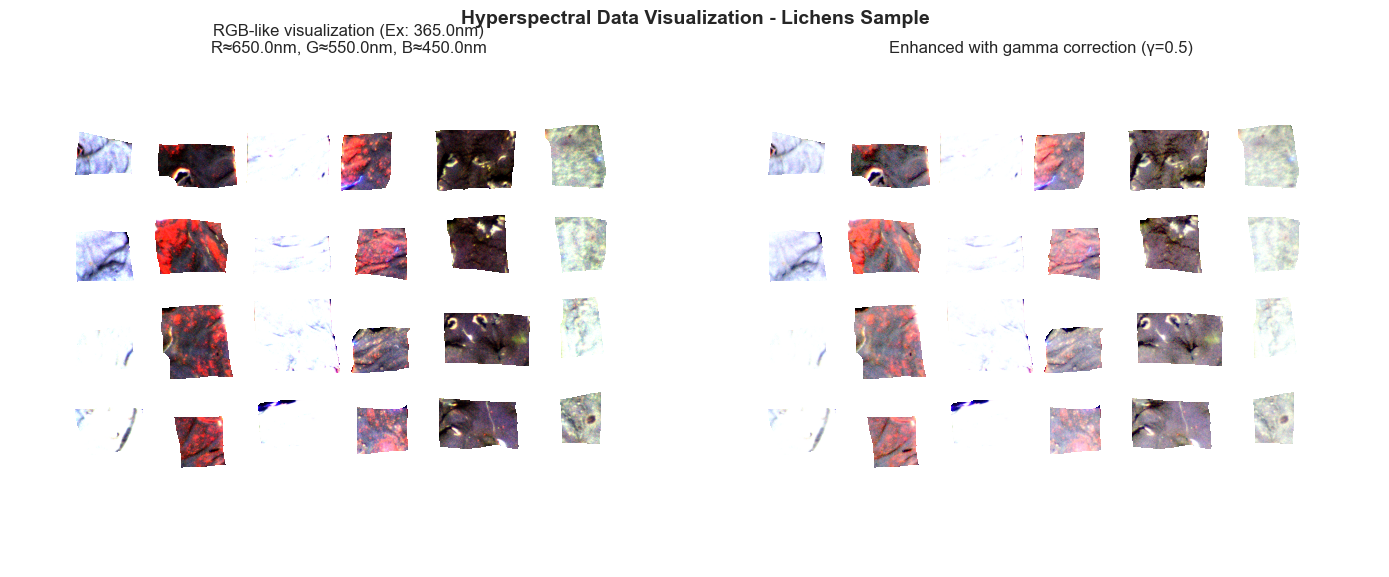

RGB visualization created using excitation 365.0nm
  Red channel: 650.0nm (index 23)
  Green channel: 550.0nm (index 13)
  Blue channel: 450.0nm (index 3)
  Image shape: (1040, 1392, 3)


In [7]:
# Visualize RGB-like image from the hyperspectral data
print("\nCreating RGB-like visualization from hyperspectral data...")

# Select wavelengths that approximate RGB channels
# We'll use different excitations and find wavelengths close to R(~650nm), G(~550nm), B(~450nm)

# Function to find closest wavelength index
def find_closest_wavelength(wavelengths, target):
    wavelengths = np.array(wavelengths)
    idx = np.argmin(np.abs(wavelengths - target))
    return idx

# Initialize RGB channels
rgb_image = None

# Try to find good approximations for RGB from available data
# We'll use excitation 365nm as it often gives good fluorescence across spectrum
excitation_for_rgb = '365.0'  # Middle excitation wavelength

if excitation_for_rgb in full_data['data']:
    cube_data = full_data['data'][excitation_for_rgb]['cube']
    wavelengths = full_data['data'][excitation_for_rgb]['wavelengths']
    
    # Find indices for RGB-like wavelengths
    # For fluorescence data, we might need to adjust these targets
    red_idx = find_closest_wavelength(wavelengths, 650)  # Red ~650nm
    green_idx = find_closest_wavelength(wavelengths, 550)  # Green ~550nm  
    blue_idx = find_closest_wavelength(wavelengths, 450)  # Blue ~450nm
    
    # Extract the RGB channels
    red_channel = cube_data[:, :, red_idx]
    green_channel = cube_data[:, :, green_idx]
    blue_channel = cube_data[:, :, blue_idx]
    
    # Stack into RGB image
    rgb_image = np.stack([red_channel, green_channel, blue_channel], axis=2)
    
    # Normalize and enhance brightness for better visibility
    # Normalize each channel independently to use full range
    for i in range(3):
        channel = rgb_image[:, :, i]
        # Remove outliers using percentile clipping
        vmin, vmax = np.percentile(channel[channel > 0], [2, 98]) if np.any(channel > 0) else (0, 1)
        rgb_image[:, :, i] = np.clip((channel - vmin) / (vmax - vmin + 1e-10), 0, 1)
    
    # Apply brightness enhancement
    brightness_factor = 2.5  # Increase brightness
    rgb_image = np.clip(rgb_image * brightness_factor, 0, 1)
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Show enhanced RGB image
    axes[0].imshow(rgb_image)
    axes[0].set_title(f'RGB-like visualization (Ex: {excitation_for_rgb}nm)\nR≈{wavelengths[red_idx]:.1f}nm, G≈{wavelengths[green_idx]:.1f}nm, B≈{wavelengths[blue_idx]:.1f}nm')
    axes[0].axis('off')
    
    # Show with different enhancement for more detail
    # Apply gamma correction for better visibility of dark areas
    gamma = 0.5
    rgb_gamma = np.power(rgb_image, gamma)
    axes[1].imshow(rgb_gamma)
    axes[1].set_title(f'Enhanced with gamma correction (γ={gamma})')
    axes[1].axis('off')
    
    plt.suptitle(f'Hyperspectral Data Visualization - {sample_name} Sample', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"RGB visualization created using excitation {excitation_for_rgb}nm")
    print(f"  Red channel: {wavelengths[red_idx]:.1f}nm (index {red_idx})")
    print(f"  Green channel: {wavelengths[green_idx]:.1f}nm (index {green_idx})")
    print(f"  Blue channel: {wavelengths[blue_idx]:.1f}nm (index {blue_idx})")
    print(f"  Image shape: {rgb_image.shape}")
else:
    print(f"Warning: Excitation {excitation_for_rgb}nm not found in data")
    print(f"Available excitations: {full_data['excitation_wavelengths']}")

In [26]:
# Extract ground truth
print("\nExtracting ground truth...")

background_colors = [
    (24, 24, 24, 255),      # Dark gray background
    (168, 168, 168, 255)    # Light gray background
]

ground_truth, color_mapping, lichen_colors = extract_ground_truth_from_png(
    png_path,
    background_colors=background_colors,
    target_shape=(1040, 1392)
)

n_true_classes = len(lichen_colors)
print(f"Ground truth extracted")
print(f"  Number of classes: {n_true_classes}")
print(f"  Shape: {ground_truth.shape}")


Extracting ground truth...
Original PNG shape: (1024, 1392)
Resized to: (1040, 1392)
Found 8 unique colors in the PNG
Found 6 lichen type colors (excluding background)

Ground Truth Statistics:
  Shape: (1040, 1392)
  Number of lichen types: 6
  Type 0 (color (np.uint8(48), np.uint8(48), np.uint8(48), np.uint8(255))): 66698 pixels (4.61%)
  Type 1 (color (np.uint8(72), np.uint8(72), np.uint8(72), np.uint8(255))): 43625 pixels (3.01%)
  Type 2 (color (np.uint8(96), np.uint8(96), np.uint8(96), np.uint8(255))): 68789 pixels (4.75%)
  Type 3 (color (np.uint8(120), np.uint8(120), np.uint8(120), np.uint8(255))): 43942 pixels (3.04%)
  Type 4 (color (np.uint8(144), np.uint8(144), np.uint8(144), np.uint8(255))): 59920 pixels (4.14%)
  Type 5 (color (np.uint8(217), np.uint8(217), np.uint8(217), np.uint8(255))): 44485 pixels (3.07%)
  Background: 1120221 pixels (77.38%)
Ground truth extracted
  Number of classes: 6
  Shape: (1040, 1392)


Current data shape information:
  Full spatial dimensions: 1040 x 0 pixels

Cropping data to horizontal range: 467 to 830
Original spatial dimensions: 1040 x 0
New spatial dimensions: 1040 x 363
Data successfully cropped
  New data shape: (1040, 0, 22)
  New ground truth shape: (1040, 1392)

Final working dimensions:
  Spatial: 1040 x 0 pixels
  Ground truth: (1040, 1392)
  Total pixels for analysis: 1,447,680


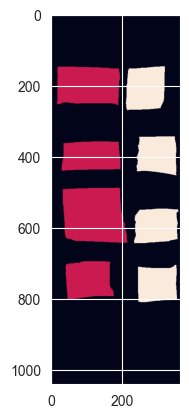

In [30]:
# Crop data to horizontal range: 0 to 855 pixels
# This will analyze only the leftmost 855 pixels of the image

print("Current data shape information:")
sample_ex = str(full_data['excitation_wavelengths'][0])
sample_shape = full_data['data'][sample_ex]['cube'].shape
print(f"  Full spatial dimensions: {sample_shape[0]} x {sample_shape[1]} pixels")

# Set cropping parameters
start_col = 1392 - 925
end_col = 830

print(f"\nCropping data to horizontal range: {start_col} to {end_col}")
print(f"Original spatial dimensions: {sample_shape[0]} x {sample_shape[1]}")
print(f"New spatial dimensions: {sample_shape[0]} x {end_col - start_col}")

# Create cropped version of full_data
cropped_data = {
    'excitation_wavelengths': full_data['excitation_wavelengths'],
    'metadata': full_data.get('metadata', {}),
    'data': {}
}

# Crop each excitation wavelength's data
for ex in full_data['excitation_wavelengths']:
    ex_str = str(ex)
    original_cube = full_data['data'][ex_str]['cube']

    # Crop the spatial dimensions (keeping all spectral bands)
    cropped_cube = original_cube[:, start_col:end_col, :]

    # Copy all metadata but replace cube with cropped version
    cropped_data['data'][ex_str] = {
        **full_data['data'][ex_str],
        'cube': cropped_cube
    }

# Also crop the ground truth mask to match
ground_truth_cropped = ground_truth[:, start_col:end_col]

# Update the working datasets
full_data = cropped_data
ground_truth = ground_truth_cropped

print(f"Data successfully cropped")
print(f"  New data shape: {cropped_cube.shape}")
print(f"  New ground truth shape: {ground_truth.shape}")

print(f"\nFinal working dimensions:")
working_shape = full_data['data'][sample_ex]['cube'].shape
print(f"  Spatial: {working_shape[0]} x {working_shape[1]} pixels")
print(f"  Ground truth: {ground_truth.shape}")
print(f"  Total pixels for analysis: {ground_truth.size:,}")
plt.imshow(ground_truth_cropped)

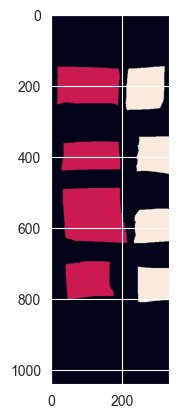

## 4. Baseline: Full Data Clustering

BASELINE: Clustering with Full Data
Starting improved data concatenation...
Found 8 excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Spatial dimensions: 1040 x 333
Finding valid pixels...
Found 92082 valid pixels out of 346320 total (26.6%)
Valid pixel coordinates range: x[0-292], y[131-800]
Extracting spectral data for valid pixels...
Extracted spectral data shape: (92082, 192)
Applying global normalization using method: global_percentile
  Used percentiles: P5=14.99, P95=722.27
Created DataFrame with shape: (92082, 194)
  - 92082 valid pixels (rows)
  - 194 features (columns): 2 integer coordinates + 192 spectral features
  - Coordinate types: x=int64, y=int64
  - Spectral data range: [0.0000, 1.0000]
    Exported concatenated data to: BASELINE_FULL_DATA_concatenated_data.csv

Baseline Results:
  Features: 192
  Purity: 0.9323
  ARI: 0.7475
  NMI: 0.6969
  Silhouette: 0.4205


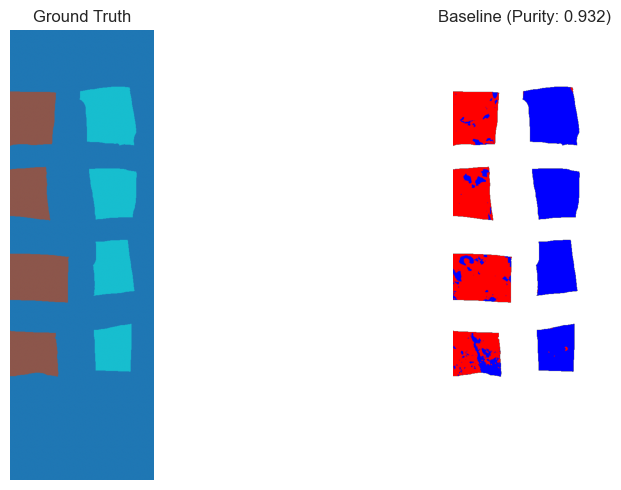

In [13]:
print("="*80)
print("BASELINE: Clustering with Full Data")
print("="*80)
n_clusters = 4  # Using 4 clusters to match 4 ROI regions

# Create ROI colormap for consistent visualization
roi_colormap = create_roi_colormap(ROI_REGIONS)

# Run clustering on full data with concatenated data export
cluster_map_full, metrics_full, n_features_full = run_clustering_pipeline(
    full_data,
    n_clusters,  # Use n_clusters (4) instead of n_true_classes
    export_concat_data=True,
    config_name="BASELINE_FULL_DATA"
)

# Calculate ground truth metrics
baseline_metrics = calculate_clustering_accuracy(
    cluster_map_full,
    ground_truth,
    np.ones_like(ground_truth, dtype=bool)
)

print(f"\nBaseline Results:")
print(f"  Features: {n_features_full}")
print(f"  Purity: {baseline_metrics['purity']:.4f}")
print(f"  ARI: {baseline_metrics['adjusted_rand_score']:.4f}")
print(f"  NMI: {baseline_metrics['normalized_mutual_info']:.4f}")
print(f"  Silhouette: {metrics_full['silhouette_score']:.4f}")

# Save baseline visualization with ROI colors
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(ground_truth, cmap='tab10')
axes[0].set_title('Ground Truth')
axes[0].axis('off')

# Create a masked array for proper visualization (mask -1 values)
cluster_map_display = np.ma.masked_where(cluster_map_full == -1, cluster_map_full)
axes[1].imshow(cluster_map_display, cmap=roi_colormap, vmin=0, vmax=len(ROI_REGIONS)-1)
axes[1].set_title(f'Baseline (Purity: {baseline_metrics["purity"]:.3f})')
axes[1].axis('off')

plt.tight_layout()
plt.savefig(visualizations_dir / "baseline.png", dpi=150, bbox_inches='tight')
plt.show()

# NEW: Save baseline result image separately for paper
baseline_only_fig = plt.figure(figsize=(8, 8))
cluster_map_display = np.ma.masked_where(cluster_map_full == -1, cluster_map_full)
plt.imshow(cluster_map_display, cmap=roi_colormap, vmin=0, vmax=len(ROI_REGIONS)-1)
plt.title(f'Baseline Full Data\nPurity: {baseline_metrics["purity"]:.3f}', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.savefig(paper_results_dir / "baseline_full_data.png", dpi=300, bbox_inches='tight')
plt.close()

In [11]:
# ============================================================================
# VISUALIZE BASELINE CLUSTERING
# ============================================================================

if 'baseline_labels' in locals():
    print("\n📊 Creating baseline clustering visualizations...")

    # Export baseline clustering overlay
    baseline_overlay = export_roi_overlay(
        mask=mask,
        labels=baseline_labels,
        save_path=vis_dir / "overlays" / "baseline_clustering.png",
        title=f"Baseline Clustering (All {len(wavelengths)} wavelengths)",
        color_palette=VIZ_PALETTE,
        dpi=VIZ_DPI
    )

    # Calculate advanced metrics for baseline
    if 'data_pca' in locals():
        baseline_metrics = calculate_advanced_metrics(data_pca, baseline_labels)
        print(f"  Baseline Silhouette Score: {baseline_metrics['silhouette']:.4f}")
        print(f"  Baseline Davies-Bouldin: {baseline_metrics['davies_bouldin']:.4f}")
        print(f"  Baseline Calinski-Harabasz: {baseline_metrics['calinski_harabasz']:.4f}")

    print("  ✓ Baseline visualizations saved")


## 5. Define Wavelength Selection Configurations

In [12]:
configurations = [
      # === VARIANCE-BASED METHODS (Best Performers) ===
    {
        'name': 'conservative_activation',
        'dimension_selection_method': 'activation',
        'perturbation_method': 'percentile',
        'perturbation_magnitudes': [10, 20, 30],
        'n_important_dimensions': 10,
        'n_bands_to_select': 10,
        'normalization_method': 'variance'
    },
    {
        'name': 'conservative_variance',
        'dimension_selection_method': 'variance',
        'perturbation_method': 'standard_deviation',
        'perturbation_magnitudes': [15, 30, 45],
        'n_important_dimensions': 10,
        'n_bands_to_select': 10,
        'normalization_method': 'max_per_excitation'
    },
    {
        'name': 'conservative_pca',
        'dimension_selection_method': 'pca',
        'perturbation_method': 'absolute_range',
        'perturbation_magnitudes': [20, 40, 60],
        'n_important_dimensions': 8,
        'n_bands_to_select': 10,
        'normalization_method': 'variance'
    },

    # Minimal approaches (10 wavelengths)
    {
        'name': 'minimal_activation',
        'dimension_selection_method': 'activation',
        'perturbation_method': 'percentile',
        'perturbation_magnitudes': [20, 40, 60],
        'n_important_dimensions': 5,
        'n_bands_to_select': 10,
        'normalization_method': 'variance'
    },
    {
        'name': 'minimal_variance',
        'dimension_selection_method': 'variance',
        'perturbation_method': 'standard_deviation',
        'perturbation_magnitudes': [25, 50, 75],
        'n_important_dimensions': 5,
        'n_bands_to_select': 10,
        'normalization_method': 'max_per_excitation'
    },
    {
        'name': 'minimal_pca',
        'dimension_selection_method': 'pca',
        'perturbation_method': 'percentile',
        'perturbation_magnitudes': [30, 50, 70],
        'n_important_dimensions': 5,
        'n_bands_to_select': 10,
        'normalization_method': 'none'
    },

    # Aggressive sensitivity approaches
    {
        'name': 'aggressive_high_sensitivity',
        'dimension_selection_method': 'activation',
        'perturbation_method': 'percentile',
        'perturbation_magnitudes': [40, 60, 80],
        'n_important_dimensions': 3,
        'n_bands_to_select': 10,
        'normalization_method': 'variance'
    },
    {
        'name': 'aggressive_std_based',
        'dimension_selection_method': 'variance',
        'perturbation_method': 'standard_deviation',
        'perturbation_magnitudes': [50, 75, 100],
        'n_important_dimensions': 3,
        'n_bands_to_select': 10,
        'normalization_method': 'max_per_excitation'
    },

    # Balanced approaches
    {
        'name': 'balanced_activation_12',
        'dimension_selection_method': 'activation',
        'perturbation_method': 'percentile',
        'perturbation_magnitudes': [15, 30, 45],
        'n_important_dimensions': 7,
        'n_bands_to_select': 10,
        'normalization_method': 'variance'
    },
    {
        'name': 'balanced_variance_12',
        'dimension_selection_method': 'variance',
        'perturbation_method': 'standard_deviation',
        'perturbation_magnitudes': [20, 40, 60],
        'n_important_dimensions': 7,
        'n_bands_to_select': 10,
        'normalization_method': 'max_per_excitation'
    },
      # Fine-tune the best performing variance method with different wavelength counts
      {
          'name': 'variance_optimized_5',
          'dimension_selection_method': 'variance',
          'perturbation_method': 'standard_deviation',
          'perturbation_magnitudes': [25, 50, 75],
          'n_important_dimensions': 3,
          'n_bands_to_select': 5,
          'normalization_method': 'max_per_excitation'
      },
      {
          'name': 'variance_optimized_6',
          'dimension_selection_method': 'variance',
          'perturbation_method': 'standard_deviation',
          'perturbation_magnitudes': [20, 40, 60],
          'n_important_dimensions': 4,
          'n_bands_to_select': 6,
          'normalization_method': 'max_per_excitation'
      },
      {
          'name': 'variance_optimized_7',
          'dimension_selection_method': 'variance',
          'perturbation_method': 'standard_deviation',
          'perturbation_magnitudes': [20, 40, 60],
          'n_important_dimensions': 4,
          'n_bands_to_select': 7,
          'normalization_method': 'max_per_excitation'
      },
      {
          'name': 'variance_optimized_8',
          'dimension_selection_method': 'variance',
          'perturbation_method': 'standard_deviation',
          'perturbation_magnitudes': [15, 30, 45],
          'n_important_dimensions': 5,
          'n_bands_to_select': 8,
          'normalization_method': 'max_per_excitation'
      },
      {
          'name': 'variance_optimized_9',
          'dimension_selection_method': 'variance',
          'perturbation_method': 'standard_deviation',
          'perturbation_magnitudes': [15, 30, 45],
          'n_important_dimensions': 6,
          'n_bands_to_select': 9,
          'normalization_method': 'max_per_excitation'
      },
      {
          'name': 'variance_optimized_10',
          'dimension_selection_method': 'variance',
          'perturbation_method': 'standard_deviation',
          'perturbation_magnitudes': [15, 30, 45],
          'n_important_dimensions': 7,
          'n_bands_to_select': 10,
          'normalization_method': 'max_per_excitation'
      },
      {
          'name': 'variance_optimized_11',
          'dimension_selection_method': 'variance',
          'perturbation_method': 'standard_deviation',
          'perturbation_magnitudes': [12, 25, 40],
          'n_important_dimensions': 8,
          'n_bands_to_select': 11,
          'normalization_method': 'max_per_excitation'
      },
      {
          'name': 'variance_optimized_12',
          'dimension_selection_method': 'variance',
          'perturbation_method': 'standard_deviation',
          'perturbation_magnitudes': [10, 20, 35],
          'n_important_dimensions': 8,
          'n_bands_to_select': 12,
          'normalization_method': 'max_per_excitation'
      },

      # === VARIANCE WITH ALTERNATIVE NORMALIZATION ===

      {
          'name': 'variance_alt_norm_6',
          'dimension_selection_method': 'variance',
          'perturbation_method': 'standard_deviation',
          'perturbation_magnitudes': [20, 40, 60],
          'n_important_dimensions': 4,
          'n_bands_to_select': 6,
          'normalization_method': 'variance'
      },
      {
          'name': 'variance_alt_norm_8',
          'dimension_selection_method': 'variance',
          'perturbation_method': 'standard_deviation',
          'perturbation_magnitudes': [15, 30, 45],
          'n_important_dimensions': 5,
          'n_bands_to_select': 8,
          'normalization_method': 'variance'
      },
      {
          'name': 'variance_alt_norm_10',
          'dimension_selection_method': 'variance',
          'perturbation_method': 'standard_deviation',
          'perturbation_magnitudes': [15, 30, 45],
          'n_important_dimensions': 7,
          'n_bands_to_select': 10,
          'normalization_method': 'variance'
      },

      # === VARIANCE WITH PERCENTILE PERTURBATION ===

      {
          'name': 'variance_percentile_6',
          'dimension_selection_method': 'variance',
          'perturbation_method': 'percentile',
          'perturbation_magnitudes': [15, 30, 50],
          'n_important_dimensions': 4,
          'n_bands_to_select': 6,
          'normalization_method': 'max_per_excitation'
      },
      {
          'name': 'variance_percentile_8',
          'dimension_selection_method': 'variance',
          'perturbation_method': 'percentile',
          'perturbation_magnitudes': [10, 25, 40],
          'n_important_dimensions': 5,
          'n_bands_to_select': 8,
          'normalization_method': 'max_per_excitation'
      },
      {
          'name': 'variance_percentile_10',
          'dimension_selection_method': 'variance',
          'perturbation_method': 'percentile',
          'perturbation_magnitudes': [10, 20, 35],
          'n_important_dimensions': 7,
          'n_bands_to_select': 10,
          'normalization_method': 'max_per_excitation'
      },

      # === PCA METHODS (Moderate performers, good diversity) ===

      {
          'name': 'pca_optimized_5',
          'dimension_selection_method': 'pca',
          'perturbation_method': 'percentile',
          'perturbation_magnitudes': [20, 40, 60],
          'n_important_dimensions': 3,
          'n_bands_to_select': 5,
          'normalization_method': 'none'
      },
      {
          'name': 'pca_optimized_7',
          'dimension_selection_method': 'pca',
          'perturbation_method': 'percentile',
          'perturbation_magnitudes': [15, 30, 50],
          'n_important_dimensions': 4,
          'n_bands_to_select': 7,
          'normalization_method': 'variance'
      },
      {
          'name': 'pca_optimized_9',
          'dimension_selection_method': 'pca',
          'perturbation_method': 'absolute_range',
          'perturbation_magnitudes': [20, 40, 60],
          'n_important_dimensions': 6,
          'n_bands_to_select': 9,
          'normalization_method': 'variance'
      },
      {
          'name': 'pca_optimized_11',
          'dimension_selection_method': 'pca',
          'perturbation_method': 'absolute_range',
          'perturbation_magnitudes': [15, 30, 45],
          'n_important_dimensions': 7,
          'n_bands_to_select': 11,
          'normalization_method': 'variance'
      },

      # === HYBRID APPROACHES ===

      {
          'name': 'hybrid_conservative_6',
          'dimension_selection_method': 'variance',
          'perturbation_method': 'standard_deviation',
          'perturbation_magnitudes': [10, 20, 30],
          'n_important_dimensions': 8,
          'n_bands_to_select': 6,
          'normalization_method': 'max_per_excitation'
      },
      {
          'name': 'hybrid_aggressive_8',
          'dimension_selection_method': 'variance',
          'perturbation_method': 'standard_deviation',
          'perturbation_magnitudes': [30, 60, 90],
          'n_important_dimensions': 4,
          'n_bands_to_select': 8,
          'normalization_method': 'max_per_excitation'
      },
      {
          'name': 'hybrid_pca_variance_7',
          'dimension_selection_method': 'pca',
          'perturbation_method': 'standard_deviation',
          'perturbation_magnitudes': [20, 40, 60],
          'n_important_dimensions': 4,
          'n_bands_to_select': 7,
          'normalization_method': 'max_per_excitation'
      },

      # === FINE-TUNED ACTIVATION (Limited exploration) ===

      {
          'name': 'activation_improved_8',
          'dimension_selection_method': 'activation',
          'perturbation_method': 'percentile',
          'perturbation_magnitudes': [5, 10, 20],
          'n_important_dimensions': 6,
          'n_bands_to_select': 8,
          'normalization_method': 'variance'
      },
      {
          'name': 'activation_improved_10',
          'dimension_selection_method': 'activation',
          'perturbation_method': 'standard_deviation',
          'perturbation_magnitudes': [10, 20, 30],
          'n_important_dimensions': 8,
          'n_bands_to_select': 10,
          'normalization_method': 'max_per_excitation'
      },

      # === EDGE CASES FOR VALIDATION ===

      {
          'name': 'minimal_5_high_importance',
          'dimension_selection_method': 'variance',
          'perturbation_method': 'standard_deviation',
          'perturbation_magnitudes': [15, 30, 45],
          'n_important_dimensions': 10,
          'n_bands_to_select': 5,
          'normalization_method': 'max_per_excitation'
      },
      {
          'name': 'maximal_12_low_importance',
          'dimension_selection_method': 'variance',
          'perturbation_method': 'standard_deviation',
          'perturbation_magnitudes': [25, 50, 75],
          'n_important_dimensions': 3,
          'n_bands_to_select': 12,
          'normalization_method': 'max_per_excitation'
      },
  ]



print(f"Defined {len(configurations)} configurations to test:")
for config in configurations:
    print(f"{config['name']}: {config['n_bands_to_select']} bands, "
          f"{config['dimension_selection_method']} method")

Defined 35 configurations to test:
conservative_activation: 10 bands, activation method
conservative_variance: 10 bands, variance method
conservative_pca: 10 bands, pca method
minimal_activation: 10 bands, activation method
minimal_variance: 10 bands, variance method
minimal_pca: 10 bands, pca method
aggressive_high_sensitivity: 10 bands, activation method
aggressive_std_based: 10 bands, variance method
balanced_activation_12: 10 bands, activation method
balanced_variance_12: 10 bands, variance method
variance_optimized_5: 5 bands, variance method
variance_optimized_6: 6 bands, variance method
variance_optimized_7: 7 bands, variance method
variance_optimized_8: 8 bands, variance method
variance_optimized_9: 9 bands, variance method
variance_optimized_10: 10 bands, variance method
variance_optimized_11: 11 bands, variance method
variance_optimized_12: 12 bands, variance method
variance_alt_norm_6: 6 bands, variance method
variance_alt_norm_8: 8 bands, variance method
variance_alt_norm_1

## 6. Run All Configurations

In [13]:
# Initialize results storage
results = []
all_combinations = []  # Store all wavelength combinations for detailed analysis

print("="*80)
print("RUNNING WAVELENGTH SELECTION CONFIGURATIONS")
print("="*80)

for i, config in enumerate(tqdm(configurations, desc="Testing configurations")):
    config_name = config['name']
    print(f"\n[{i+1}/{len(configurations)}] Running: {config_name}")
    
    try:
        # Step 1: Select wavelengths (FIXED function with combination tracking)
        wavelength_combinations, emission_wavelengths_only, selection_results = select_informative_wavelengths_fixed(
            data_path, 
            mask_path,
            sample_name,
            config,
            verbose=False
        )
        
        print(f"  Selected {len(wavelength_combinations)} wavelength combinations")
        if wavelength_combinations:
            print(f"  Example: {wavelength_combinations[0]['combination_name']}")
        
        # Step 2: Extract subset (using emission wavelengths for compatibility)
        subset_data = extract_wavelength_subset(
            full_data,
            emission_wavelengths_only,
            verbose=True
        )
        
        # Step 3: Run clustering with concatenated data export
        cluster_map, metrics, n_features = run_clustering_pipeline(
            subset_data,
            n_clusters,  # Use n_clusters (4) instead of n_true_classes
            export_concat_data=True,  # NEW: Export concatenated data
            config_name=config_name   # NEW: Pass config name for file naming
        )
        
        # Step 4: Validate against ground truth
        gt_metrics = calculate_clustering_accuracy(
            cluster_map,
            ground_truth,
            np.ones_like(ground_truth, dtype=bool)
        )
        
        # Step 5: Save visualization (comparison)
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(ground_truth, cmap='tab10')
        axes[0].set_title('Ground Truth')
        axes[0].axis('off')
        
        # Mask -1 values for proper visualization
        cluster_map_full_display = np.ma.masked_where(cluster_map_full == -1, cluster_map_full)
        axes[1].imshow(cluster_map_full_display, cmap=roi_colormap, vmin=0, vmax=len(ROI_REGIONS)-1)
        axes[1].set_title(f'Baseline\nPurity: {baseline_metrics["purity"]:.3f}')
        axes[1].axis('off')
        
        # Mask -1 values for proper visualization
        cluster_map_display = np.ma.masked_where(cluster_map == -1, cluster_map)
        axes[2].imshow(cluster_map_display, cmap=roi_colormap, vmin=0, vmax=len(ROI_REGIONS)-1)
        axes[2].set_title(f'{config_name}\nPurity: {gt_metrics["purity"]:.3f}')
        axes[2].axis('off')
        
        plt.suptitle(f'Configuration: {config_name} ({len(wavelength_combinations)} combinations)')
        plt.tight_layout()
        plt.savefig(visualizations_dir / f"{config_name}.png", dpi=150, bbox_inches='tight')
        plt.close()
        
        # NEW: Save individual result image for paper
        individual_fig = plt.figure(figsize=(8, 8))
        cluster_map_display = np.ma.masked_where(cluster_map == -1, cluster_map)
        plt.imshow(cluster_map_display, cmap=roi_colormap, vmin=0, vmax=len(ROI_REGIONS)-1)
        plt.title(f'{config_name}\n{len(wavelength_combinations)} wavelengths | Purity: {gt_metrics["purity"]:.3f}', fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(paper_results_dir / f"{config_name}_result.png", dpi=300, bbox_inches='tight')
        plt.close()
        print(f"    Saved individual result to paper-results/{config_name}_result.png")
        
        # Store detailed wavelength combinations for this configuration
        config_combinations = []
        for combo in wavelength_combinations:
            config_combinations.append({
                'config_name': config_name,
                'excitation_nm': combo['excitation'],
                'emission_nm': combo['emission'],
                'combination_name': combo['combination_name']
            })
        all_combinations.extend(config_combinations)
        
        # Store results with detailed wavelength information
        result = {
            'config_name': config_name,
            'dimension_method': config['dimension_selection_method'],
            'perturbation_method': config['perturbation_method'],
            'n_important_dims': config['n_important_dimensions'],
            'n_combinations_selected': len(wavelength_combinations),
            'n_features': n_features,
            'data_reduction_pct': (1 - n_features/n_features_full) * 100,
            # Format wavelength combinations in readable format
            'wavelength_combinations': format_wavelength_combinations(wavelength_combinations),
            # Also keep the simple list for backward compatibility
            'emission_wavelengths_only': str(emission_wavelengths_only),
            'purity': gt_metrics['purity'],
            'ari': gt_metrics['adjusted_rand_score'],
            'nmi': gt_metrics['normalized_mutual_info'],
            'v_measure': gt_metrics['v_measure'],
            'homogeneity': gt_metrics['homogeneity'],
            'completeness': gt_metrics['completeness'],
            'silhouette': metrics['silhouette_score'],
            'davies_bouldin': metrics['davies_bouldin_score'],
            'calinski_harabasz': metrics['calinski_harabasz_score']
        }
        
        results.append(result)
        
        print(f"  Purity: {gt_metrics['purity']:.4f} | ARI: {gt_metrics['adjusted_rand_score']:.4f}")
        
    except Exception as e:
        print(f"Error: {str(e)}")
        results.append({
            'config_name': config_name,
            'error': str(e)
        })

print("\n" + "="*80)
print(f"Completed {len(results)} configurations")
print(f"Collected {len(all_combinations)} total wavelength combinations")
print(f"Exported concatenated data for each configuration to: {concat_data_dir}")
print(f"Saved individual clustering results to: {paper_results_dir}")

RUNNING WAVELENGTH SELECTION CONFIGURATIONS


Testing configurations:   0%|          | 0/35 [00:00<?, ?it/s]


[1/35] Running: conservative_activation
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 nm: 27 bands
  - Excitation 385.0 nm: 28 bands
  - Excitation 400.0 nm: 25 bands
  - Excitat

Testing configurations:   3%|▎         | 1/35 [00:36<20:32, 36.26s/it]

    Saved individual result to paper-results/conservative_activation_result.png
  Purity: 0.7777 | ARI: 0.5653

[2/35] Running: conservative_variance
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - 

Testing configurations:   6%|▌         | 2/35 [01:13<20:23, 37.09s/it]

    Saved individual result to paper-results/conservative_variance_result.png
  Purity: 0.8668 | ARI: 0.7176

[3/35] Running: conservative_pca
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitat

Testing configurations:   9%|▊         | 3/35 [01:47<18:52, 35.39s/it]

    Saved individual result to paper-results/conservative_pca_result.png
  Purity: 0.7777 | ARI: 0.5653

[4/35] Running: minimal_activation
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation

Testing configurations:  11%|█▏        | 4/35 [02:20<17:49, 34.49s/it]

    Saved individual result to paper-results/minimal_activation_result.png
  Purity: 0.7777 | ARI: 0.5653

[5/35] Running: minimal_variance
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation

Testing configurations:  14%|█▍        | 5/35 [02:57<17:43, 35.45s/it]

    Saved individual result to paper-results/minimal_variance_result.png
  Purity: 0.8682 | ARI: 0.7194

[6/35] Running: minimal_pca
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 

Testing configurations:  17%|█▋        | 6/35 [03:34<17:22, 35.95s/it]

    Saved individual result to paper-results/minimal_pca_result.png
  Purity: 0.8620 | ARI: 0.7124

[7/35] Running: aggressive_high_sensitivity
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excita

Testing configurations:  20%|██        | 7/35 [04:07<16:17, 34.92s/it]

    Saved individual result to paper-results/aggressive_high_sensitivity_result.png
  Purity: 0.7777 | ARI: 0.5653

[8/35] Running: aggressive_std_based
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
 

Testing configurations:  23%|██▎       | 8/35 [04:44<15:59, 35.54s/it]

    Saved individual result to paper-results/aggressive_std_based_result.png
  Purity: 0.8682 | ARI: 0.7194

[9/35] Running: balanced_activation_12
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Ex

Testing configurations:  26%|██▌       | 9/35 [05:16<14:56, 34.49s/it]

    Saved individual result to paper-results/balanced_activation_12_result.png
  Purity: 0.7777 | ARI: 0.5653

[10/35] Running: balanced_variance_12
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - E

Testing configurations:  29%|██▊       | 10/35 [05:54<14:49, 35.57s/it]

    Saved individual result to paper-results/balanced_variance_12_result.png
  Purity: 0.8682 | ARI: 0.7194

[11/35] Running: variance_optimized_5
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Exc

Testing configurations:  31%|███▏      | 11/35 [06:26<13:51, 34.66s/it]

    Saved individual result to paper-results/variance_optimized_5_result.png
  Purity: 0.8595 | ARI: 0.7048

[12/35] Running: variance_optimized_6
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Exc

Testing configurations:  34%|███▍      | 12/35 [07:00<13:09, 34.31s/it]

    Saved individual result to paper-results/variance_optimized_6_result.png
  Purity: 0.8589 | ARI: 0.7041

[13/35] Running: variance_optimized_7
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Exc

Testing configurations:  37%|███▋      | 13/35 [07:34<12:34, 34.32s/it]

    Saved individual result to paper-results/variance_optimized_7_result.png
  Purity: 0.8584 | ARI: 0.7029

[14/35] Running: variance_optimized_8
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Exc

Testing configurations:  40%|████      | 14/35 [08:09<12:03, 34.46s/it]

    Saved individual result to paper-results/variance_optimized_8_result.png
  Purity: 0.8654 | ARI: 0.7146

[15/35] Running: variance_optimized_9
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Exc

Testing configurations:  43%|████▎     | 15/35 [08:45<11:40, 35.00s/it]

    Saved individual result to paper-results/variance_optimized_9_result.png
  Purity: 0.8652 | ARI: 0.7149

[16/35] Running: variance_optimized_10
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Ex

Testing configurations:  46%|████▌     | 16/35 [09:23<11:22, 35.92s/it]

    Saved individual result to paper-results/variance_optimized_10_result.png
  Purity: 0.8682 | ARI: 0.7194

[17/35] Running: variance_optimized_11
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - E

Testing configurations:  49%|████▊     | 17/35 [10:02<11:01, 36.78s/it]

    Saved individual result to paper-results/variance_optimized_11_result.png
  Purity: 0.8666 | ARI: 0.7173

[18/35] Running: variance_optimized_12
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - E

Testing configurations:  51%|█████▏    | 18/35 [10:42<10:40, 37.67s/it]

    Saved individual result to paper-results/variance_optimized_12_result.png
  Purity: 0.8666 | ARI: 0.7173

[19/35] Running: variance_alt_norm_6
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Exc

Testing configurations:  54%|█████▍    | 19/35 [11:25<10:29, 39.37s/it]

    Saved individual result to paper-results/variance_alt_norm_6_result.png
  Purity: 0.8167 | ARI: 0.6459

[20/35] Running: variance_alt_norm_8
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excit

Testing configurations:  57%|█████▋    | 20/35 [12:06<09:55, 39.69s/it]

    Saved individual result to paper-results/variance_alt_norm_8_result.png
  Purity: 0.8145 | ARI: 0.6449

[21/35] Running: variance_alt_norm_10
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Exci

Testing configurations:  60%|██████    | 21/35 [12:38<08:44, 37.46s/it]

    Saved individual result to paper-results/variance_alt_norm_10_result.png
  Purity: 0.7777 | ARI: 0.5653

[22/35] Running: variance_percentile_6
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Ex

Testing configurations:  63%|██████▎   | 22/35 [13:13<07:59, 36.90s/it]

    Saved individual result to paper-results/variance_percentile_6_result.png
  Purity: 0.8584 | ARI: 0.7029

[23/35] Running: variance_percentile_8
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - E

Testing configurations:  66%|██████▌   | 23/35 [13:50<07:22, 36.90s/it]

    Saved individual result to paper-results/variance_percentile_8_result.png
  Purity: 0.8654 | ARI: 0.7146

[24/35] Running: variance_percentile_10
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - 

Testing configurations:  69%|██████▊   | 24/35 [14:31<06:57, 37.95s/it]

    Saved individual result to paper-results/variance_percentile_10_result.png
  Purity: 0.8682 | ARI: 0.7194

[25/35] Running: pca_optimized_5
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excita

Testing configurations:  71%|███████▏  | 25/35 [15:07<06:13, 37.40s/it]

    Saved individual result to paper-results/pca_optimized_5_result.png
  Purity: 0.8603 | ARI: 0.7084

[26/35] Running: pca_optimized_7
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 36

Testing configurations:  74%|███████▍  | 26/35 [15:50<05:50, 38.98s/it]

    Saved individual result to paper-results/pca_optimized_7_result.png
  Purity: 0.8177 | ARI: 0.6497

[27/35] Running: pca_optimized_9
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 36

Testing configurations:  77%|███████▋  | 27/35 [16:24<05:00, 37.54s/it]

    Saved individual result to paper-results/pca_optimized_9_result.png
  Purity: 0.7777 | ARI: 0.5653

[28/35] Running: pca_optimized_11
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 3

Testing configurations:  80%|████████  | 28/35 [17:00<04:20, 37.20s/it]

    Saved individual result to paper-results/pca_optimized_11_result.png
  Purity: 0.7841 | ARI: 0.5755

[29/35] Running: hybrid_conservative_6
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excita

Testing configurations:  83%|████████▎ | 29/35 [17:38<03:43, 37.29s/it]

    Saved individual result to paper-results/hybrid_conservative_6_result.png
  Purity: 0.8589 | ARI: 0.7041

[30/35] Running: hybrid_aggressive_8
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Exc

Testing configurations:  86%|████████▌ | 30/35 [18:16<03:07, 37.48s/it]

    Saved individual result to paper-results/hybrid_aggressive_8_result.png
  Purity: 0.8654 | ARI: 0.7146

[31/35] Running: hybrid_pca_variance_7
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Exc

Testing configurations:  89%|████████▊ | 31/35 [18:49<02:25, 36.31s/it]

    Saved individual result to paper-results/hybrid_pca_variance_7_result.png
  Purity: 0.8561 | ARI: 0.7021

[32/35] Running: activation_improved_8
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - E

Testing configurations:  91%|█████████▏| 32/35 [19:34<01:56, 38.94s/it]

    Saved individual result to paper-results/activation_improved_8_result.png
  Purity: 0.8145 | ARI: 0.6449

[33/35] Running: activation_improved_10
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - 

Testing configurations:  94%|█████████▍| 33/35 [20:17<01:20, 40.06s/it]

    Saved individual result to paper-results/activation_improved_10_result.png
  Purity: 0.8703 | ARI: 0.7234

[34/35] Running: minimal_5_high_importance
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands


Testing configurations:  97%|█████████▋| 34/35 [20:53<00:38, 38.74s/it]

    Saved individual result to paper-results/minimal_5_high_importance_result.png
  Purity: 0.8595 | ARI: 0.7048

[35/35] Running: maximal_12_low_importance
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 327459/1447680 valid pixels (22.62%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 ban

Testing configurations: 100%|██████████| 35/35 [21:34<00:00, 36.98s/it]

    Saved individual result to paper-results/maximal_12_low_importance_result.png
  Purity: 0.8682 | ARI: 0.7194

Completed 35 configurations
Collected 304 total wavelength combinations
Exported concatenated data for each configuration to: C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\validation_results\20251006_140406\concat-data
Saved individual clustering results to: C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\validation_results\20251006_140406\paper-results


## 7. Compile and Save Results

In [14]:
# Create DataFrame from results
df_results = pd.DataFrame(results)

# Add baseline row
baseline_row = {
    'config_name': 'BASELINE_FULL_DATA',
    'dimension_method': 'N/A',
    'perturbation_method': 'N/A',
    'n_important_dims': 'N/A',
    'n_combinations_selected': total_bands,
    'n_features': n_features_full,
    'data_reduction_pct': 0.0,
    'wavelength_combinations': 'ALL_EXCITATION_EMISSION_PAIRS',
    'emission_wavelengths_only': 'ALL',
    'purity': baseline_metrics['purity'],
    'ari': baseline_metrics['adjusted_rand_score'],
    'nmi': baseline_metrics['normalized_mutual_info'],
    'v_measure': baseline_metrics['v_measure'],
    'homogeneity': baseline_metrics['homogeneity'],
    'completeness': baseline_metrics['completeness'],
    'silhouette': metrics_full['silhouette_score'],
    'davies_bouldin': metrics_full['davies_bouldin_score'],
    'calinski_harabasz': metrics_full['calinski_harabasz_score']
}

df_results = pd.concat([pd.DataFrame([baseline_row]), df_results], ignore_index=True)

# Sort by purity
df_results = df_results.sort_values('purity', ascending=False)

# Create detailed combinations DataFrame
df_combinations = pd.DataFrame(all_combinations)

print("Results DataFrames created:")
print(f"\nMain Results: {len(df_results)} configurations")
print(df_results[['config_name', 'n_combinations_selected', 'purity', 'ari', 'nmi']].head(10))

if not df_combinations.empty:
    print(f"\nDetailed Combinations: {len(df_combinations)} excitation-emission pairs")
    print(df_combinations.head())

Results DataFrames created:

Main Results: 36 configurations
                  config_name  n_combinations_selected    purity       ari  \
33     activation_improved_10                       10  0.870276  0.723423   
8        aggressive_std_based                       10  0.868196  0.719437   
5            minimal_variance                       10  0.868196  0.719437   
10       balanced_variance_12                       10  0.868196  0.719437   
24     variance_percentile_10                       10  0.868196  0.719437   
35  maximal_12_low_importance                       12  0.868196  0.719437   
16      variance_optimized_10                       10  0.868196  0.719437   
2       conservative_variance                       10  0.866823  0.717609   
18      variance_optimized_12                       12  0.866622  0.717304   
17      variance_optimized_11                       11  0.866622  0.717304   

         nmi  
33  0.723371  
8   0.721263  
5   0.721263  
10  0.721263  
24  0

In [15]:
# Save to Excel and CSV
excel_path = results_dir / "wavelength_selection_results.xlsx"
csv_path = results_dir / "wavelength_selection_results.csv"

# Save to Excel with multiple sheets
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    # Main results sheet
    df_results.to_excel(writer, sheet_name='Configuration_Results', index=False)
    
    # Detailed wavelength combinations sheet
    if not df_combinations.empty:
        df_combinations.to_excel(writer, sheet_name='Wavelength_Combinations', index=False)
    
    # Summary sheet
    best_purity_idx = df_results['purity'].idxmax()
    best_ari_idx = df_results['ari'].idxmax() 
    best_nmi_idx = df_results['nmi'].idxmax()
    best_reduction_idx = df_results['data_reduction_pct'].idxmax()
    
    summary = pd.DataFrame({
        'Metric': ['Best Purity', 'Best ARI', 'Best NMI', 'Most Data Reduction'],
        'Configuration': [
            df_results.loc[best_purity_idx, 'config_name'],
            df_results.loc[best_ari_idx, 'config_name'],
            df_results.loc[best_nmi_idx, 'config_name'],
            df_results.loc[best_reduction_idx, 'config_name']
        ],
        'Value': [
            f"{df_results.loc[best_purity_idx, 'purity']:.4f}",
            f"{df_results.loc[best_ari_idx, 'ari']:.4f}",
            f"{df_results.loc[best_nmi_idx, 'nmi']:.4f}",
            f"{df_results.loc[best_reduction_idx, 'data_reduction_pct']:.1f}%"
        ],
        'Wavelength_Combinations': [
            str(df_results.loc[best_purity_idx, 'wavelength_combinations'])[:100] + "..." if len(str(df_results.loc[best_purity_idx, 'wavelength_combinations'])) > 100 else str(df_results.loc[best_purity_idx, 'wavelength_combinations']),
            str(df_results.loc[best_ari_idx, 'wavelength_combinations'])[:100] + "..." if len(str(df_results.loc[best_ari_idx, 'wavelength_combinations'])) > 100 else str(df_results.loc[best_ari_idx, 'wavelength_combinations']),
            str(df_results.loc[best_nmi_idx, 'wavelength_combinations'])[:100] + "..." if len(str(df_results.loc[best_nmi_idx, 'wavelength_combinations'])) > 100 else str(df_results.loc[best_nmi_idx, 'wavelength_combinations']),
            str(df_results.loc[best_reduction_idx, 'wavelength_combinations'])[:100] + "..." if len(str(df_results.loc[best_reduction_idx, 'wavelength_combinations'])) > 100 else str(df_results.loc[best_reduction_idx, 'wavelength_combinations'])
        ]
    })
    summary.to_excel(writer, sheet_name='Summary', index=False)
    
    # Wavelength frequency analysis sheet
    if not df_combinations.empty:
        # Count how often each excitation-emission combination appears
        combo_counts = df_combinations.groupby(['excitation_nm', 'emission_nm']).agg({
            'config_name': 'count',
            'combination_name': 'first'
        }).rename(columns={'config_name': 'frequency'}).sort_values('frequency', ascending=False)
        
        combo_counts.to_excel(writer, sheet_name='Combination_Frequency')
        
        # Excitation wavelength popularity
        ex_popularity = df_combinations.groupby('excitation_nm')['config_name'].count().sort_values(ascending=False)
        ex_popularity.to_excel(writer, sheet_name='Excitation_Popularity')

# Save main results to CSV
df_results.to_csv(csv_path, index=False)

# Save combinations to separate CSV
if not df_combinations.empty:
    combinations_csv = results_dir / "wavelength_combinations_detailed.csv"
    df_combinations.to_csv(combinations_csv, index=False)
    print(f"  Combinations CSV: {combinations_csv}")

print(f"\nResults saved to:")
print(f"  Excel (multi-sheet): {excel_path}")
print(f"    - Configuration_Results: Main results with wavelength combinations")
if not df_combinations.empty:
    print(f"    - Wavelength_Combinations: Detailed excitation-emission pairs")
    print(f"    - Combination_Frequency: Most commonly selected wavelength pairs")
    print(f"    - Excitation_Popularity: Most useful excitation wavelengths")
print(f"    - Summary: Best configurations by metric")
print(f"  CSV: {csv_path}")

  Combinations CSV: C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\validation_results\20251006_140406\wavelength_combinations_detailed.csv

Results saved to:
  Excel (multi-sheet): C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\validation_results\20251006_140406\wavelength_selection_results.xlsx
    - Configuration_Results: Main results with wavelength combinations
    - Wavelength_Combinations: Detailed excitation-emission pairs
    - Combination_Frequency: Most commonly selected wavelength pairs
    - Excitation_Popularity: Most useful excitation wavelengths
    - Summary: Best configurations by metric
  CSV: C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\validation_results\20251006_140406\wavelength_selection_results.csv


In [16]:
# ============================================================================
# METHOD COMPARISONS AND ANALYSIS (SAFE VERSION)
# ============================================================================

if 'results' in locals() and len(results) > 0:
    print("\n🔍 Checking data structure for visualizations...")

    # First, let's check what keys are available in results
    if results:
        print(f"  Available keys in first result: {results[0].keys()}")

    # Check if we have cluster labels stored separately
    cluster_labels_available = False

    # Try to find cluster labels - they might be stored differently
    if 'cluster_labels' in results[0]:
        cluster_labels_available = True
        print("  ✓ Found cluster_labels in results")
    else:
        print("  ⚠️ cluster_labels not found in results dictionary")
        print("  Note: Cluster labels might be stored separately in your pipeline")
        print("  Skipping method comparison visualizations")

    # Only run if we have the required data
    if cluster_labels_available:
        print("\n🔍 Creating method comparison visualizations...")

        # Find best result
        best_result = max(results, key=lambda x: x['purity'])

        # Compare baseline with best method if available
        if 'baseline_labels' in locals() and 'cluster_labels' in best_result:
            agreement = create_method_comparison(
                labels1=baseline_labels,
                labels2=best_result['cluster_labels'],
                mask=mask,
                save_path=vis_dir / "comparisons" / "baseline_vs_best.png",
                method1_name="Baseline (All wavelengths)",
                method2_name=f"Best ({best_result['num_wavelengths']} wavelengths)",
                dpi=VIZ_DPI
            )
            print(f"  Agreement between baseline and best: {agreement:.2f}%")

        # Compare top methods if cluster labels exist
        sorted_results = sorted(results, key=lambda x: x['purity'], reverse=True)
        if len(sorted_results) >= 2:
            if 'cluster_labels' in sorted_results[0] and 'cluster_labels' in sorted_results[1]:
                agreement = create_method_comparison(
                    labels1=sorted_results[0]['cluster_labels'],
                    labels2=sorted_results[1]['cluster_labels'],
                    mask=mask,
                    save_path=vis_dir / "comparisons" / "top1_vs_top2.png",
                    method1_name=f"Top 1 ({sorted_results[0]['num_wavelengths']} WLs)",
                    method2_name=f"Top 2 ({sorted_results[1]['num_wavelengths']} WLs)",
                    dpi=VIZ_DPI
                )
                print(f"  Agreement between top 2 methods: {agreement:.2f}%")

        print("  ✓ Method comparisons saved")



🔍 Creating method comparison visualizations...


KeyError: 'cluster_labels'

## 8. Analysis and Visualization

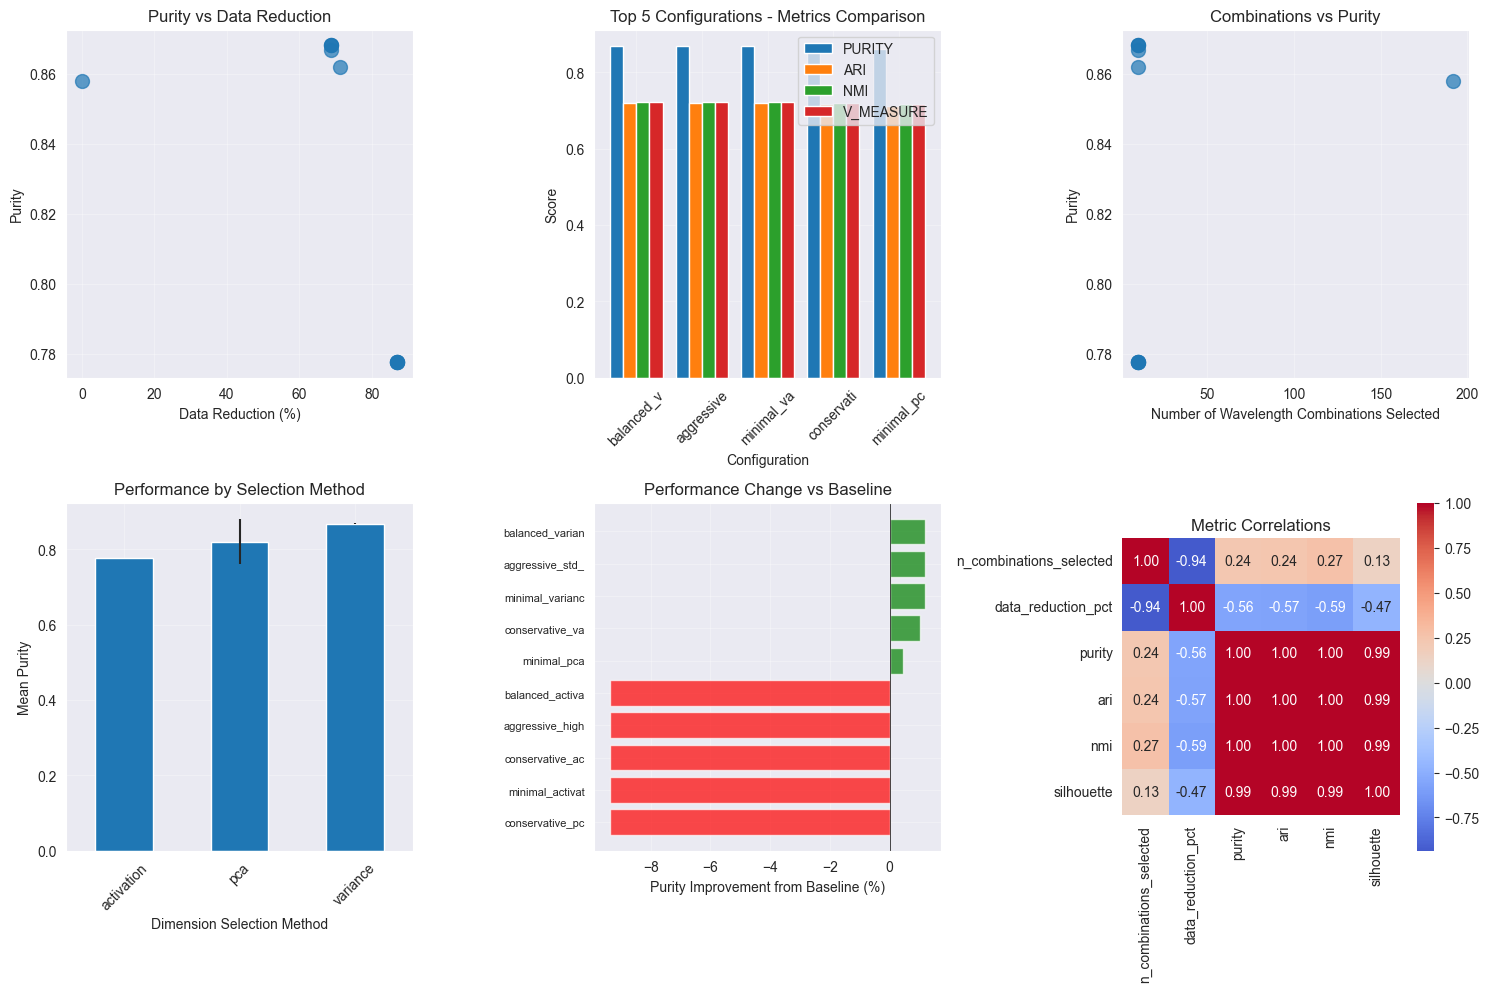

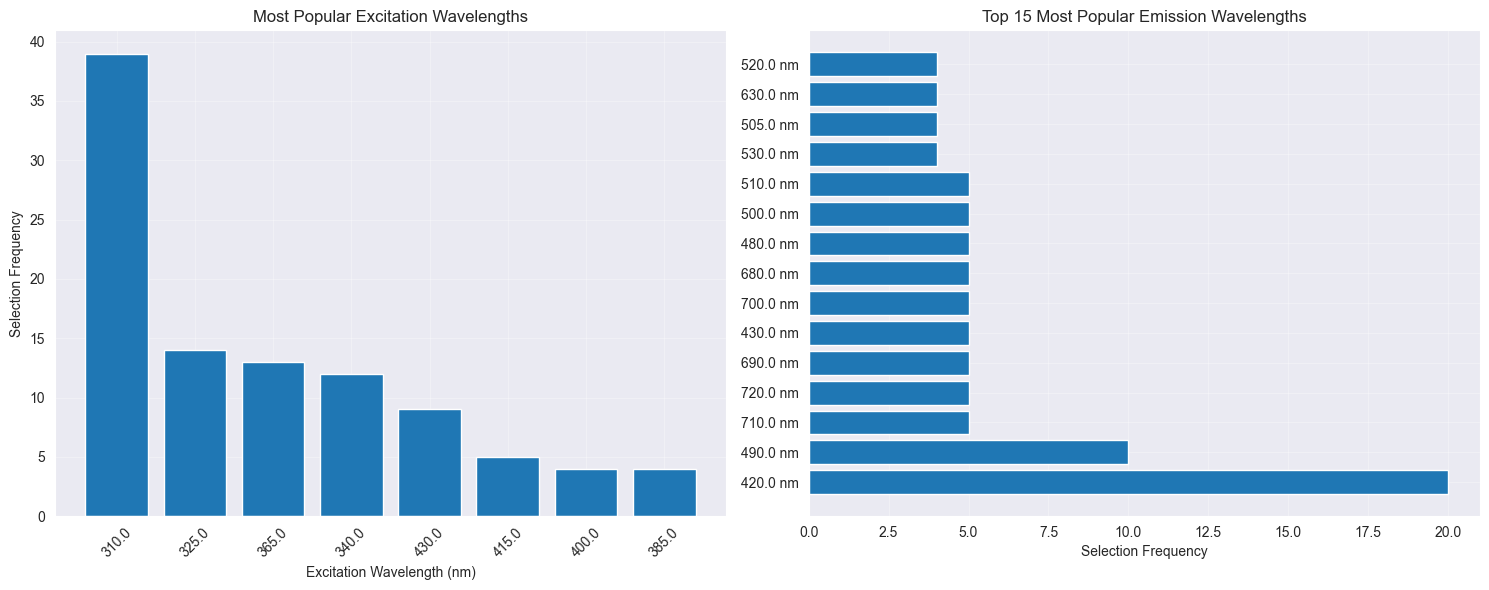

✓ Analysis plots saved


In [39]:
# Create comprehensive comparison plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1: Purity vs Data Reduction
axes[0, 0].scatter(df_results['data_reduction_pct'], df_results['purity'], s=100, alpha=0.7)
axes[0, 0].set_xlabel('Data Reduction (%)')
axes[0, 0].set_ylabel('Purity')
axes[0, 0].set_title('Purity vs Data Reduction')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Metrics comparison bar plot
metrics_cols = ['purity', 'ari', 'nmi', 'v_measure']
top_5 = df_results.nlargest(5, 'purity')
x = np.arange(len(top_5))
width = 0.2

for i, metric in enumerate(metrics_cols):
    axes[0, 1].bar(x + i*width, top_5[metric], width, label=metric.upper())

axes[0, 1].set_xlabel('Configuration')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Top 5 Configurations - Metrics Comparison')
axes[0, 1].set_xticks(x + width * 1.5)
axes[0, 1].set_xticklabels([c[:10] for c in top_5['config_name']], rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Number of combinations vs Purity
axes[0, 2].scatter(df_results['n_combinations_selected'], df_results['purity'], s=100, alpha=0.7)
axes[0, 2].set_xlabel('Number of Wavelength Combinations Selected')
axes[0, 2].set_ylabel('Purity')
axes[0, 2].set_title('Combinations vs Purity')
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Method comparison
valid_methods = df_results[df_results['dimension_method'] != 'N/A']
if not valid_methods.empty:
    method_results = valid_methods.groupby('dimension_method')['purity'].agg(['mean', 'std'])
    method_results.plot(kind='bar', y='mean', yerr='std', ax=axes[1, 0], legend=False)
    axes[1, 0].set_xlabel('Dimension Selection Method')
    axes[1, 0].set_ylabel('Mean Purity')
    axes[1, 0].set_title('Performance by Selection Method')
    axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Purity improvement from baseline
baseline_purity = df_results[df_results['config_name'] == 'BASELINE_FULL_DATA']['purity'].values[0]
df_results['purity_improvement'] = ((df_results['purity'] - baseline_purity) / baseline_purity) * 100

improvement_data = df_results[df_results['config_name'] != 'BASELINE_FULL_DATA'].sort_values('purity_improvement')
colors = ['green' if x >= 0 else 'red' for x in improvement_data['purity_improvement']]

axes[1, 1].barh(range(len(improvement_data)), improvement_data['purity_improvement'], color=colors, alpha=0.7)
axes[1, 1].set_yticks(range(len(improvement_data)))
axes[1, 1].set_yticklabels([c[:15] for c in improvement_data['config_name']], fontsize=8)
axes[1, 1].set_xlabel('Purity Improvement from Baseline (%)')
axes[1, 1].set_title('Performance Change vs Baseline')
axes[1, 1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Correlation matrix
corr_cols = ['n_combinations_selected', 'data_reduction_pct', 'purity', 'ari', 'nmi', 'silhouette']
available_cols = [col for col in corr_cols if col in df_results.columns]
corr_data = df_results[available_cols].select_dtypes(include=[np.number])
corr_matrix = corr_data.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, ax=axes[1, 2])
axes[1, 2].set_title('Metric Correlations')

plt.tight_layout()
plt.savefig(results_dir / "analysis_summary.png", dpi=300, bbox_inches='tight')
plt.show()

# Additional plot: Wavelength combination popularity
if not df_combinations.empty:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Most popular excitation wavelengths
    ex_counts = df_combinations['excitation_nm'].value_counts()
    axes[0].bar(ex_counts.index.astype(str), ex_counts.values)
    axes[0].set_xlabel('Excitation Wavelength (nm)')
    axes[0].set_ylabel('Selection Frequency')
    axes[0].set_title('Most Popular Excitation Wavelengths')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3)
    
    # Top emission wavelengths
    em_counts = df_combinations['emission_nm'].value_counts().head(15)
    axes[1].barh(range(len(em_counts)), em_counts.values)
    axes[1].set_yticks(range(len(em_counts)))
    axes[1].set_yticklabels([f"{em:.1f} nm" for em in em_counts.index])
    axes[1].set_xlabel('Selection Frequency')
    axes[1].set_title('Top 15 Most Popular Emission Wavelengths')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(results_dir / "wavelength_popularity.png", dpi=300, bbox_inches='tight')
    plt.show()

print("Analysis plots saved")

## 9. Final Summary

In [ ]:
print("="*80)
print("WAVELENGTH SELECTION VALIDATION - FINAL SUMMARY")
print("="*80)

print("\nBASELINE PERFORMANCE:")
print(f"  Features: {n_features_full}")
print(f"  Purity: {baseline_metrics['purity']:.4f}")
print(f"  ARI: {baseline_metrics['adjusted_rand_score']:.4f}")
print(f"  NMI: {baseline_metrics['normalized_mutual_info']:.4f}")

print("\n BEST CONFIGURATIONS:")
if not df_results.empty:
    print("\n  By Purity:")
    best_purity = df_results.loc[df_results['purity'].idxmax()]
    print(f"    Config: {best_purity['config_name']}")
    print(f"    Combinations: {best_purity['n_combinations_selected']} ({best_purity['data_reduction_pct']:.1f}% reduction)")
    print(f"    Purity: {best_purity['purity']:.4f}")
    print(f"    Wavelengths: {best_purity['wavelength_combinations'][:100]}...")

    print("\n  By ARI:")
    best_ari = df_results.loc[df_results['ari'].idxmax()]
    print(f"    Config: {best_ari['config_name']}")
    print(f"    Combinations: {best_ari['n_combinations_selected']} ({best_ari['data_reduction_pct']:.1f}% reduction)")
    print(f"    ARI: {best_ari['ari']:.4f}")

print("\n RESULTS SAVED TO:")
print(f"  Main Directory: {results_dir}")
print(f"  \n  Excel file: wavelength_selection_results.xlsx")
print(f"    - Configuration_Results: Main results with excitation-emission combinations")
if not df_combinations.empty:
    print(f"    - Wavelength_Combinations: Detailed wavelength pairs per configuration")
    print(f"    - Combination_Frequency: Most commonly selected wavelength pairs")
    print(f"    - Excitation_Popularity: Most useful excitation wavelengths")
print(f"  \n  CSV file: wavelength_selection_results.csv")
print(f"  \n  Visualizations: {visualizations_dir}")
print(f"    - {len(list(visualizations_dir.glob('*.png')))} comparison images saved")
print(f"  \n  Paper Results: {paper_results_dir}")
print(f"    - Individual clustering result images for each configuration (high DPI)")
print(f"    - {len(list(paper_results_dir.glob('*.png')))} individual result images")
print(f"  \n  Concatenated Data: {concat_data_dir}")
print(f"    - CSV files with concatenated hyperspectral data for each configuration")
print(f"    - {len(list(concat_data_dir.glob('*.csv')))} data files exported")

print("\n Pipeline completed successfully!")
print("\nKey Features Added:")
print("   1. Individual clustering result images in paper-results folder (300 DPI)")
print("   2. ROI-based color consistency in clustering visualizations")
print("   3. Concatenated datasets exported to concat-data folder for further analysis")
print("   4. Excitation-emission wavelength combinations clearly tracked in Excel")

In [ ]:
# ============================================================================
# WAVELENGTH IMPORTANCE ANALYSIS (SAFE VERSION)
# ============================================================================

if 'results' in locals() and 'wavelengths' in locals():
    print("\n📈 Analyzing wavelength importance...")

    # Calculate importance based on selection frequency weighted by purity
    importance_scores = np.zeros(len(wavelengths))

    for result in results:
        # Check different possible key names for wavelength indices
        wl_indices = None

        if 'wavelength_indices' in result:
            wl_indices = result['wavelength_indices']
        elif 'selected_indices' in result:
            wl_indices = result['selected_indices']
        elif 'indices' in result:
            wl_indices = result['indices']
        elif 'selected_wavelengths' in result:
            # Convert wavelength values to indices
            for wl in result['selected_wavelengths']:
                idx = np.argmin(np.abs(wavelengths - wl))
                if importance_scores is not None:
                    importance_scores[idx] += result['purity']
            continue

        if wl_indices is not None:
            for idx in wl_indices:
                if idx < len(wavelengths):
                    importance_scores[idx] += result['purity']

    # Only create visualization if we found any wavelength data
    if np.sum(importance_scores) > 0:
        # Normalize
        importance_scores = importance_scores / np.max(importance_scores)

        # Create importance visualization
        create_wavelength_importance_plot(
            importance_scores=importance_scores,
            wavelengths=wavelengths,
            save_path=vis_dir / "wavelength_importance" / "importance_analysis.png",
            title="Wavelength Importance Analysis",
            dpi=VIZ_DPI,
            top_n=20
        )

        # Print top 10 important wavelengths
        top_indices = np.argsort(importance_scores)[-10:][::-1]
        print("\n  Top 10 Most Important Wavelengths:")
        for i, idx in enumerate(top_indices):
            print(f"    {i+1:2d}. {wavelengths[idx]:.1f} nm (score: {importance_scores[idx]:.3f})")

        print("\n  ✓ Wavelength importance analysis saved")
    else:
        print("  ⚠️ No wavelength selection data found in results")
        print("  Skipping wavelength importance visualization")


In [ ]:
# ============================================================================
# CALCULATE ADVANCED CLUSTERING METRICS (SAFE VERSION)
# ============================================================================

if 'results' in locals() and 'data_pca' in locals():
    print("\n📊 Checking for clustering data...")

    # Check if cluster labels are available
    has_labels = any('cluster_labels' in r for r in results if isinstance(r, dict))

    if has_labels:
        print("  Calculating advanced clustering metrics...")

        # Calculate advanced metrics for results that have cluster labels
        for result in results:
            if isinstance(result, dict) and 'cluster_labels' in result:
                metrics = calculate_advanced_metrics(data_pca, result['cluster_labels'])
                result['silhouette_score'] = metrics['silhouette']
                result['davies_bouldin'] = metrics['davies_bouldin']
                result['calinski_harabasz'] = metrics['calinski_harabasz']

        # Create enhanced DataFrame
        df_results_enhanced = pd.DataFrame(results)

        # Save enhanced results
        df_results_enhanced.to_csv(vis_dir / "clustering_metrics" / "results_with_metrics.csv", index=False)
        df_results_enhanced.to_excel(vis_dir / "clustering_metrics" / "results_with_metrics.xlsx", index=False)

        print("  ✓ Advanced metrics calculated and saved")
    else:
        print("  ⚠️ No cluster labels found in results")
        print("  Creating basic results summary instead...")

        # Still save the basic results
        df_results = pd.DataFrame(results)
        df_results.to_csv(vis_dir / "clustering_metrics" / "results_summary.csv", index=False)
        df_results.to_excel(vis_dir / "clustering_metrics" / "results_summary.xlsx", index=False)

        print("  ✓ Basic results summary saved")

    # Print summary of top methods regardless of cluster labels
    df_display = pd.DataFrame(results)
    print("\n  Top 5 Methods by Purity:")
    print("  " + "="*50)
    top_5 = df_display.nlargest(5, 'purity')

    for i, (_, row) in enumerate(top_5.iterrows()):
        print(f"\n  Rank {i+1}:")
        print(f"    Wavelengths: {row['num_wavelengths']}")
        print(f"    Purity: {row['purity']:.4f}")
        print(f"    Data Reduction: {row['data_reduction_pct']:.1f}%")

        # Only print advanced metrics if they exist
        if 'silhouette_score' in row:
            print(f"    Silhouette: {row['silhouette_score']:.4f}")
        if 'davies_bouldin' in row:
            print(f"    Davies-Bouldin: {row['davies_bouldin']:.4f}")
        if 'calinski_harabasz' in row:
            print(f"    Calinski-Harabasz: {row['calinski_harabasz']:.2f}")


In [ ]:
# ============================================================================
# GENERATE ALL COMPREHENSIVE VISUALIZATIONS (SAFE VERSION)
# ============================================================================

if 'results' in locals():
    print("\n" + "="*70)
    print("🎨 GENERATING COMPREHENSIVE VISUALIZATION SUITE")
    print("="*70)

    # First check what data is available
    print("\n📋 Checking available data...")
    available_data = {
        'results': 'results' in locals(),
        'mask': 'mask' in locals(),
        'wavelengths': 'wavelengths' in locals(),
        'hypercube': 'hypercube' in locals(),
        'latent_features': 'latent_features' in locals(),
        'baseline_labels': 'baseline_labels' in locals()
    }

    for key, available in available_data.items():
        status = "✓" if available else "✗"
        print(f"  {status} {key}")

    # Create basic visualizations that don't require cluster labels
    print("\n📊 Creating basic analysis visualizations...")

    # Convert results to DataFrame
    df_results = pd.DataFrame(results)

    # 1. Purity vs Data Reduction plot (always available)
    fig, ax = plt.subplots(figsize=(10, 6))
    scatter = ax.scatter(df_results['data_reduction_pct'],
                        df_results['purity'],
                        c=df_results['num_wavelengths'],
                        s=100, cmap='viridis', alpha=0.6)
    ax.set_xlabel('Data Reduction (%)')
    ax.set_ylabel('Purity Score')
    ax.set_title('Purity vs Data Reduction Trade-off')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Number of Wavelengths')
    plt.savefig(vis_dir / "paper_ready" / "purity_vs_reduction.png", dpi=VIZ_DPI, bbox_inches='tight')
    plt.close()
    print("  ✓ Purity vs reduction plot saved")

    # 2. Top methods bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    top_5 = df_results.nlargest(5, 'purity')
    x = range(len(top_5))
    bars = ax.bar(x, top_5['purity'].values, color=COLOR_PALETTES['paper'][:5], alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels([f"{row['num_wavelengths']} WLs" for _, row in top_5.iterrows()])
    ax.set_ylabel('Purity Score')
    ax.set_title('Top 5 Methods by Purity')
    ax.set_ylim([top_5['purity'].min() * 0.95, top_5['purity'].max() * 1.02])

    # Add value labels
    for bar, val in zip(bars, top_5['purity'].values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{val:.4f}', ha='center', va='bottom')

    plt.savefig(vis_dir / "paper_ready" / "top_methods.png", dpi=VIZ_DPI, bbox_inches='tight')
    plt.close()
    print("  ✓ Top methods chart saved")

    # 3. Try to generate the full paper figure if we have the basic requirements
    if 'mask' in locals() and 'wavelengths' in locals():
        try:
            # Find best result (just for metadata, don't need cluster_labels)
            best_result = df_results.iloc[df_results['purity'].idxmax()].to_dict()

            # Try to create paper figure (it will handle missing data gracefully)
            create_paper_figure(
                results_df=df_results,
                best_result=best_result,
                mask=mask,
                wavelengths=wavelengths,
                save_path=vis_dir / "paper_ready" / "main_figure.png"
            )
            print("  ✓ Main paper figure generated")
        except Exception as e:
            print(f"  ⚠️ Could not generate full paper figure: {e}")

    # Generate any additional visualizations if cluster labels are available
    has_cluster_labels = any('cluster_labels' in r for r in results if isinstance(r, dict))

    if has_cluster_labels:
        print("\n📊 Generating clustering-based visualizations...")
        # Call the full visualization function
        try:
            generate_all_visualizations(
                results=results,
                mask=mask,
                wavelengths=wavelengths,
                hypercube=hypercube if 'hypercube' in locals() else None,
                base_dir=vis_dir
            )
        except Exception as e:
            print(f"  ⚠️ Some visualizations could not be generated: {e}")

    print("\n" + "="*70)
    print("✅ VISUALIZATION GENERATION COMPLETE!")
    print(f"📁 Output directory: {vis_dir}")
    print("="*70)

    # List generated files
    import os
    if vis_dir.exists():
        print("\n📂 Generated files:")
        for subdir in vis_dir.iterdir():
            if subdir.is_dir():
                files = list(subdir.glob('*'))
                if files:
                    print(f"\n  {subdir.name}/")
                    for file in files[:3]:
                        print(f"    - {file.name}")
                    if len(files) > 3:
                        print(f"    ... and {len(files)-3} more files")
